# INTRODUCTION

A recommendation will be done based on the the rating statistics until a given date. That's why, a configuration parameter **RECOMMMENDATION_DATE** will be used as input parameter.

If you are looking for a ranking function that optimizes consumption, an obvious baseline is item popularity. The reason is clear: on average, a member is most likely to watch what most others are watching. However, popularity is the opposite of personalization: it will produce the same ordering of items for every member. Thus, the goal becomes to find a personalized ranking function that is better than item popularity, so we can better satisfy members with varying tastes.

Recall that our goal is to recommend the titles that each member is most likely to play and enjoy. One obvious way to approach this is to use the member’s predicted rating of each item as an adjunct to item popularity. Using predicted ratings on their own as a ranking function can lead to items that are too niche or unfamiliar being recommended, and can exclude items that the member would want to watch even though they may not rate them highly. To compensate for this, rather than using either popularity or predicted rating on their own, we would like to produce rankings that balance both of these aspects. At this point, we are ready to build a ranking prediction model using these two features.

There are many ways one could construct a ranking function ranging from simple scoring methods, to pairwise preferences, to optimization over the entire ranking. For the purposes of illustration, let us start with a very simple scoring approach by choosing our ranking function to be a linear combination of popularity and predicted rating. This gives an equation of the form frank(u,v) = w1 p(v) + w2 r(u,v) + b, where u=user, v=video item, p=popularity and r=predicted rating.

Once we have such a function, we can pass a set of videos through our function and sort them in descending order according to the score. You might be wondering how we can set the weights w1 and w2 in our model (the bias b is constant and thus ends up not affecting the final ordering). In other words, in our simple two-dimensional model, how do we determine whether popularity is more or less important than predicted rating? There are at least two possible approaches to this. You could sample the space of possible weights and let the members decide what makes sense after many A/B tests. This procedure might be time consuming and not very cost effective. Another possible answer involves formulating this as a machine learning problem: select positive and negative examples from your historical data and let a machine learning algorithm learn the weights that optimize your goal. This family of machine learning problems is known as “Learning to rank” and is central to application scenarios such as search engines or ad targeting. Note though that a crucial difference in the case of ranked recommendations is the importance of personalization: we do not expect a global notion of relevance, but rather look for ways of optimizing a personalized model.

**Baseline**

We already mentioned item popularity as a baseline. But, there are many ways to compute popularity. We can compute it over various time ranges, for instance hourly, daily, or weekly. Or, we can group members by region or other similarity metrics and compute popularity within that group.

In [1]:
gc_dt_RECOMMENDATION_DATE = '2005-08-01'

# LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import sklearn.metrics

# DATA SOURCE

Data is downloaded from the link https://www.kaggle.com/datasets/san1201/movielens1m?select=ml-1m.train.csv

## Users

In [3]:
aColNamesUsers = ['user_id', 'gender', 'age', 'occupation','zip_code']
dfUsers = pd.read_csv(r'Data\users.dat', delimiter = '::', names =aColNamesUsers , engine = 'python', encoding='latin-1', index_col = 'user_id')
dfCopyUsers = dfUsers.copy()
dfUsers.head()

,gender,age,occupation,zip_code
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


## Movies

In [4]:
aColNamesMovies = ['movie_id', 'title', 'genres']
dfMovies = pd.read_csv(r'Data\movies.dat', delimiter = '::', names =aColNamesMovies , engine = 'python', encoding='latin-1', index_col = 'movie_id')
dfCopyMovies = dfMovies.copy()
dfMovies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


## Ratings

In [5]:
aColNamesRatings = ['user_id', 'movie_id', 'rating' ,'timestamp']
dfRatings = pd.read_csv(r'Data\ratings.dat', delimiter = '::', names =aColNamesRatings , engine = 'python')
dfCopyRatings = dfRatings.copy()
dfRatings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Genres

In [6]:
gc_a_GENRES = [
	"Action",
	"Adventure", 
	"Animation", 
	"Children's", 
	"Comedy", 
	"Crime", 
	"Documentary", 
	"Drama", 
	"Fantasy", 
	"Film-Noir", 
	"Horror", 
	"Musical", 
	"Mystery", 
	"Romance", 
	"Sci-Fi", 
	"Thriller", 
	"War",
	"Western"
]
gc_a_GENRES

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

# PREPROCESSING

## Check Duplications

In [7]:
dfMovies.index.nunique() == dfMovies.shape[0]

True

In [8]:
dfMovies['title'].nunique() == dfMovies.shape[0]

True

In [9]:
dfUsers.index.nunique() == dfUsers.shape[0]

True

In [10]:
(dfRatings['user_id'].astype(str) + ', ' + dfRatings['movie_id'].astype(str)).nunique()  == dfRatings.shape[0]

True

## Convert Timestamp of Ratings to Date Time Format

In [11]:
dfRatings['timestamp'] = pd.to_datetime(dfRatings['timestamp'], unit = 's')

## Extract Year of Release of Movies

After moving the ""year_of_release"" from ""title"" there can be duplicated names. It means that same movie name has different release years. (e.g., <i>Hamlet</i>)

In [12]:
dfMovies['year_of_release'] = dfMovies['title'].str[-5:-1].astype(int)
dfMovies['title'] = dfMovies['title'].str[:-7]

In [13]:
dfMovies[dfMovies['title'] == 'Hamlet']

,title,genres,year_of_release
movie_id,,,
1411,Hamlet,Drama,1996
1941,Hamlet,Drama,1948
2820,Hamlet,Drama,1964
3598,Hamlet,Drama,2000
3723,Hamlet,Drama,1990


## Check Consistency of Rating Timestamp and Year of Release

In [14]:
dfToCheck = pd.merge(left = dfRatings , right = dfMovies['year_of_release'], left_on = 'movie_id', right_index = True)
dfToCheck[dfToCheck['timestamp'].dt.year < dfToCheck['year_of_release']]

,user_id,movie_id,rating,timestamp,year_of_release


## Identify The First Rating Date of Movies

In [15]:
dfFirstRatingDateOfMovies =  dfRatings[['movie_id', 'timestamp']].groupby('movie_id').min()
dfFirstRatingDateOfMovies

,timestamp
movie_id,
1,2000-04-26 01:34:09
2,2000-04-26 03:20:38
3,2000-04-26 01:42:52
4,2000-04-26 01:22:00
5,2000-04-26 01:39:25
...,...
3948,2000-10-07 19:21:22
3949,2000-11-05 18:49:37
3950,2000-11-14 23:37:28


## Identify First Rating Day of Users

In [16]:
dfFirstRatingDateOfUsers =  dfRatings[['user_id', 'timestamp']].groupby('user_id').min()
dfFirstRatingDateOfUsers

,timestamp
user_id,
1,2000-12-31 22:00:19
2,2000-12-31 21:28:44
3,2000-12-31 21:10:18
4,2000-12-31 20:18:44
5,2000-12-31 05:37:52
...,...
6036,2000-04-26 00:35:49
6037,2000-04-26 00:29:57
6038,2000-04-25 23:53:47


## Filter Ratings Earlier Than Given Date

In [17]:
ixRatingsToDrop = dfRatings[dfRatings['timestamp'] > gc_dt_RECOMMENDATION_DATE ].index
dfRatings.drop(ixRatingsToDrop, axis = 0, inplace = True)

## Drop Users Who Start To Rate After Given Date

In [18]:
ixUsersToDrop = dfFirstRatingDateOfUsers[dfFirstRatingDateOfUsers['timestamp'] > gc_dt_RECOMMENDATION_DATE].index
dfUsers.drop(ixUsersToDrop, axis = 0 , inplace = True)

## Drop Movies That Are Started To Be Rated After Given Date

In [19]:
ixMoviesToDrop = dfFirstRatingDateOfMovies[dfFirstRatingDateOfMovies['timestamp'] > gc_dt_RECOMMENDATION_DATE].index
dfMovies.drop(ixMoviesToDrop, axis = 0 , inplace = True)

## Transform Genres of Movies to One Hot Vector

In [20]:
for sGenre in gc_a_GENRES:
    dfMovies.loc[:, sGenre] = dfMovies.loc[: ,'genres'].str.contains(sGenre).astype(int)
    
dfMovies.drop(['genres'], axis = 1, inplace = True)
dfMovies

,title,year_of_release,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,Tigerland,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Remove Non-Numeric Columns from Movies Dataset

In [21]:
dfMovies.drop(['title'], axis = 1, inplace = True)

## Calculate Number of Users per Rating of Movie

Avoided to use statistics such as average number of rating per movie. It could be so that a movie can be rated few times, and it may be in the same category with the movies that are rated many times.

In [22]:
# dfNrOfRatingPerMovie = dfRatings.reset_index()[['movie_id','rating', 'user_id']].groupby(['movie_id', 'rating']).agg(
#     nr_of_rates=pd.NamedAgg(column='user_id', aggfunc='count')).reset_index()

# dfNrOfRatingPerMovie = dfNrOfRatingPerMovie.pivot(index = 'movie_id', columns = 'rating', values = 'nr_of_rates').add_prefix('rating_')
# dfNrOfRatingPerMovie.fillna(0, inplace = True)
# dfNrOfRatingPerMovie = dfNrOfRatingPerMovie.astype(np.int)
# dfNrOfRatingPerMovie

In [23]:
# dfMovies = pd.merge(left = dfMovies, right= dfNrOfRatingPerMovie, left_index = True, right_index = True, how = 'left')
# dfMovies.fillna(0, inplace = True)

## Merge Ratings with Movies

In [24]:
dfRatings = pd.merge(left= dfRatings, right= dfMovies, left_on = 'movie_id', right_index = True)

## Encode Movie ID and Item Id in Ratings Dataset

In [25]:
oMovieEncoder = OrdinalEncoder()
dfRatings['movie_id_encoded'] =  oMovieEncoder.fit_transform(dfRatings['movie_id'].values.reshape(-1 , 1))

oUserEncoder = OrdinalEncoder()
dfRatings['user_id_encoded'] =  oUserEncoder.fit_transform(dfRatings['user_id'].values.reshape(-1 , 1))

## Normalize Rating

In [26]:
oScaler_y = MinMaxScaler()
dfRatings['rating_normalized'] = oScaler_y.fit_transform(dfRatings['rating'].values.reshape(-1, 1))

## Build Item-User Matrix

In [ ]:
dfItemUser = dfRatings.pivot(index = 'movie_id_encoded', columns = 'user_id_encoded', values = 'rating_normalized')

# MODEL DEVELOPMENT

## Split Train-Validation-Test

In [ ]:
c_fTrainingRatio = 0.7
c_fValidationRatio = 0.15
c_fTestRatio = 0.15

ixTrain,ixTest, = train_test_split(
    dfRatings.index,
    test_size=1-c_fTrainingRatio,
    shuffle=True)

ixValidation,ixTest= train_test_split(
    ixTest
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=True)

## Identify Input and Output

In [27]:
iNrOfMovies = dfRatings['movie_id_encoded'].nunique()
iNrOfUsers = dfRatings['user_id_encoded'].nunique()

In [28]:
aColsMovie_X = [ 'movie_id_encoded']
aMovie_X_Train = dfRatings.loc[ ixTrain , aColsMovie_X].values
aMovie_X_Validation = dfRatings.loc[ ixValidation , aColsMovie_X].values
aMovie_X_Test = dfRatings.loc[ ixTest , aColsMovie_X].values


aColsUser_X = ['user_id_encoded']
aUser_X_Train = dfRatings.loc[ ixTrain , aColsUser_X].values
aUser_X_Validation = dfRatings.loc[ ixValidation , aColsUser_X].values
aUser_X_Test = dfRatings.loc[ ixTest , aColsUser_X].values


aCol_y = ['rating_normalized']
a_y = dfRatings[aCol_y].values


a_y_Train = dfRatings.loc[ ixTrain , aCol_y].values
a_y_Validation = dfRatings.loc[ ixValidation , aCol_y].values
a_y_Test = dfRatings.loc[ ixTest , aCol_y].values

## Build Model

In [30]:
c_iEmbeddigSize = 50

In [31]:
aMovieInput = tf.keras.Input(
    shape = (aMovie_X.shape[1],),
    name = 'movie_input'
)

aMovieEmbedding = tf.keras.layers.Embedding(
    input_dim=iNrOfMovies, # size of vocabulary
    output_dim=c_iEmbeddigSize, # length of sequence
    embeddings_initializer="he_normal",
    embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
    name = 'movie_embedding'
)(aMovieInput)




In [32]:
aUserInput = tf.keras.Input(
    shape = (aUser_X.shape[1],),
    name = 'user_input'
)

aUserEmbedding = tf.keras.layers.Embedding(
    input_dim=iNrOfUsers, # size of vocabulary
    output_dim=c_iEmbeddigSize, # length of sequence
    embeddings_initializer="he_normal",
    embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
    name = 'user_embedding'
)(aUserInput)

In [33]:
aOutput = tf.keras.layers.Dot(
    name = 'dot_product', 
    normalize = True, 
    axes = 2)([aMovieEmbedding, aUserEmbedding])

aOutput = tf.keras.layers.Flatten()(aOutput)
aOutput = tf.keras.layers.Dense(70, activation = 'ReLU')(aOutput)
aOutput = tf.keras.layers.Dense(30, activation = 'ReLU')(aOutput)
aOutput = tf.keras.layers.Dense(1, activation = 'sigmoid')(aOutput)

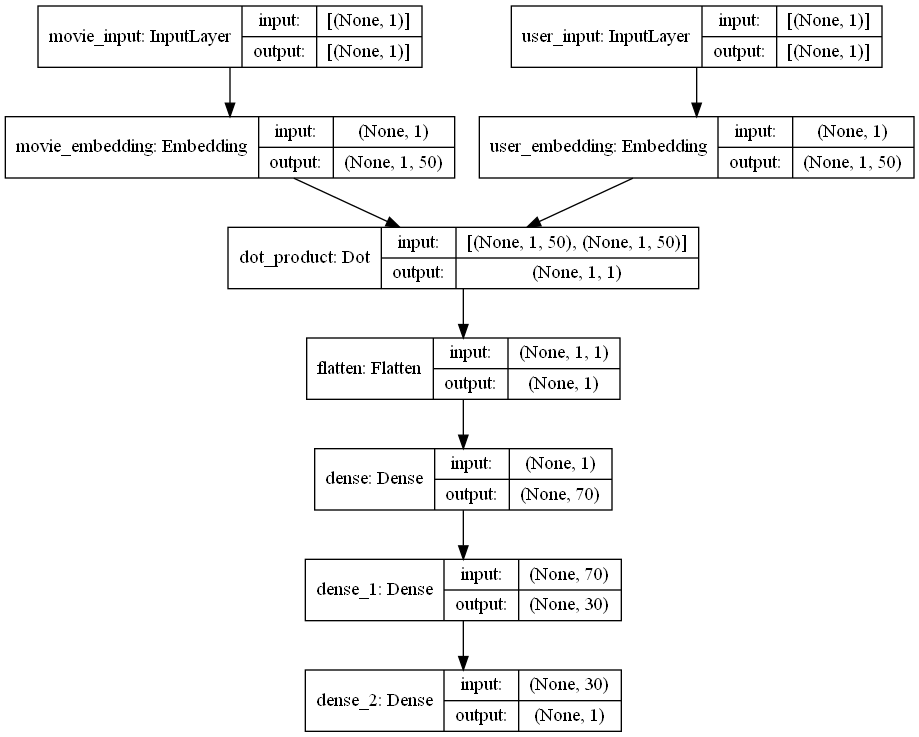

In [34]:
oModelRatingEstimator = tf.keras.Model(inputs=[aMovieInput, aUserInput], outputs=aOutput)

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-02)

oModelRatingEstimator.compile(optimizer=oOptimizer,loss= 'mse')

tf.keras.utils.plot_model(oModelRatingEstimator, show_shapes=True)

## Fit Model

In [ ]:
oEarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 50, 
    restore_best_weights = True)

oModelRatingEstimator.fit(
    [aMovie_X_Train, aUser_X_Train], 
    a_y_Train, 
    epochs= 1000, 
    batch_size=528, 
    verbose=0, 
    validation_data= ([aMovie_X_Validation, aUser_X_Validation], a_y_Validation),
    callbacks=[oEarlyStop]
)

dfHistory = pd.DataFrame(oModelRatingEstimator.history.history)

In [ ]:
plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[0:], legend = True, label = 'Validation')

## Test Model

In [ ]:
a_y_pred = oModelRatingEstimator.predict([aMovie_X_Test, aUser_X_Test])
a_y_pred = oScaler_y.inverse_transform(a_y_pred)
a_y_test = oScaler_y.inverse_transform(a_y_Test)

fMse =  sklearn.metrics.mean_squared_error(a_y_test, a_y_pred)
fRmse = np.sqrt(fMse)
fMae = sklearn.metrics.mean_absolute_error(a_y_test, a_y_pred)
fR2 =  sklearn.metrics.r2_score(a_y_test, a_y_pred)

print('MSE: {}\nRMSE: {}\nMAE: {}\nR2: {}'.format(fMse, fRmse, fMae, fR2))

# FUTURE STEPS

1. Book https://www.amazon.com/Recommender-Systems-Introduction-Dietmar-Jannach/dp/0521493366 should be read.
1. For Embedding layer of movies, vocabulary of **title** of movie can be used.
1. Scalibility is a challage. When there are millions of items. 
1. It is challange When a new user or new movie is added. Or when a person starts to rate.
1. Sequence of user ratings is important

# REFERENCES

1. https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278#:~:text=Embeddings%20are%20vector%20representations%20of,and%20user%20IDs%20as%20embeddings.
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429
1. https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5
1. https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
1. http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf
1. https://medium.com/codex/tensorflow-deep-learning-recommenders-on-retail-dataset-ce0c50aff5fa